# Classification (1) – an issue with distance measures, and an implementation of Nearest Neighbour classification

## Introduction

In this notebook we will expand on some of the concepts of 
classification, starting with an experiment with distance measures on data, then looking into the $k$-Nearest Neighbour algorithm. 

## 1) Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclidean distance in 2 and 3-dimensions, there was a warning (Slide 62 of the "Classification (1)" lecture) that in high-dimensions there is a problem – what was this problem ? 

### Pairwise distances in high-dimensional spaces 

**Answer**: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now we calculate the pairwise distances among the $N$ points.  After that for every data point we calculate the ratio of the minimum distance to the maximum distance  to all of the other data points. The mean ratio represents the average range of pairwise distances there are in that dimensionality. We run the simulation from 1 dimension to 1000 dimensions and the ratios will be plotted on a line chart using the ``` matplotlib ``` library. 

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate distances such as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

pts:  (1000, 1)
ratio_list:  0.0006881201971717949
pts:  (1000, 51)
ratio_list:  0.5392336916940544
pts:  (1000, 101)
ratio_list:  0.646963141600012
pts:  (1000, 151)
ratio_list:  0.7006610350848694
pts:  (1000, 201)
ratio_list:  0.7355044847297647
pts:  (1000, 251)
ratio_list:  0.7593662306756503
pts:  (1000, 301)
ratio_list:  0.7757335952626947
pts:  (1000, 351)
ratio_list:  0.7931416635109811
pts:  (1000, 401)
ratio_list:  0.8046824514315274
pts:  (1000, 451)
ratio_list:  0.8144630173534676
pts:  (1000, 501)
ratio_list:  0.822997956364757


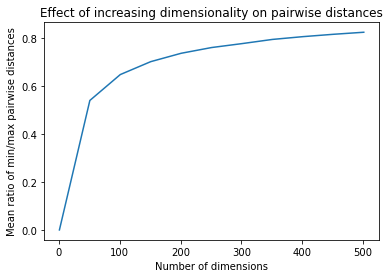

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def run_d_n(dim,N_pts,L):
    pts=np.random.rand(N_pts,dim)-0.5 # simulate N_pts points on dim dimensions space
    print('pts: ',pts.shape)
    ratio_list=[]
    for i in range(N_pts):
        # ignore the data point itself
        selected_pts=np.array([j for j in range(N_pts) if j!=i])
        #print('selected: ',selected_pts.shape)
        # calculate the L2 or L1 distance with other points
        dist=np.linalg.norm(pts[selected_pts]-pts[i],L,axis=1)
        # calculate the ratio of the min. distance to the max. distance
        ratio=np.min(dist)/np.max(dist)
        ratio_list.append(ratio)
    # output the mean ratio
    print('ratio_list: ',np.mean(ratio_list))
    return np.mean(ratio_list)

# Initialise the N_pts, the number of points we simulate
N_pts=1000
# Setting l=2 to calculate the L2 distance
l=1
# Setting the number of dimensions we simulate
check_dim=range(1,550,50)
# Calculate the mean ratio on that dimension
ratio_list=[ run_d_n(dim,N_pts,l) for dim in check_dim]
# Plot the ratio with its corresponding dimension
plt.plot(check_dim,ratio_list)
plt.ylabel("Mean ratio of min/max pairwise distances")
plt.xlabel("Number of dimensions")
plt.title("Effect of increasing dimensionality on pairwise distances")
plt.xticks(np.arange(0, 600, step=100))
plt.show()

In [7]:
a=np.array([[1,0],[1,1]])
b=np.array([1,2])
np.dot(a,b)

array([1, 3])

**Question:** how can this plot be interpreted ? How else could you visualize this effect ?

## 2) Implement Nearest Neighbour from scratch

The following will give some practise in implementing a simple classifier, the $k$-Nearest Neighbour ($k$NN) algorithm. It should help us to write a $k$NN package from scratch. Most machine learning methods include two main steps, namely training (fitting to a model to the training data) and prediction (running the model on input data  to generate output). However, in the $k$NN algorithm, since there is no explicit model-building step, we only require implementation of the prediction step without a training step.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Creation

In [12]:
mean_01 = np.array([1, 0.5])
cov_01 = np.array([[1, 0.1], [0.1, 1.2]])

mean_02 = np.array([4, 5])
cov_02 = np.array([[1, 0.1], [0.1, 1.2]])

dist_01 = np.random.multivariate_normal(mean_01, cov_01, 500)
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 500)
print(dist_01.shape, dist_02.shape)

(500, 2) (500, 2)


We have created two 2-dimensional normal distributions of data points with the same covariance but different means.

## Plotting the created Data 

What does the data look like ? Notice the 2 unique clusters being formed.

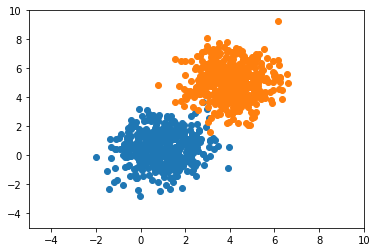

In [13]:
plt.figure(0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.scatter(dist_01[:, 0], dist_01[:, 1])
plt.scatter(dist_02[:, 0], dist_02[:, 1])#, color='red')
plt.show()

Let us now represent it in a tabular way. We will have dist_01 getting label 1.

In [14]:
r = dist_01.shape[0] + dist_02.shape[0]
c = dist_01.shape[1] + 1
data = np.zeros((r, c))
print(data.shape)

data[:dist_01.shape[0], :2] = dist_01
data[dist_01.shape[0]:, :2] = dist_02
data[dist_01.shape[0]:, -1] = 1.0

print(data.mean(axis=0))

(1000, 3)
[2.51648405 2.80105178 0.5       ]


Now shuffle the data and check by printing the first 10 rows.

In [15]:
np.random.shuffle(data)
print(data[:10])

[[-1.37710159  1.0943182   0.        ]
 [ 2.52389784  4.72684665  1.        ]
 [ 1.3890666   0.51780868  0.        ]
 [ 5.12792458  6.02518813  1.        ]
 [ 3.18550696  5.773212    1.        ]
 [ 1.5174317   1.19611605  0.        ]
 [ 3.29858777  2.89595293  1.        ]
 [ 4.128707    6.32898592  1.        ]
 [ 2.32702071  4.33926419  1.        ]
 [ 0.8326591  -0.63006695  0.        ]]


**Implementation.** Next, we implement our KNN algorithm. There are many ways to do this, but a basic approach will require a pairwise distance measure for instances, and a way to take a "training" dataset of classified instances and make a prediction for a "test" data instance. Here is a top-level outline:

In [16]:
def distance(x1, x2):
    #TODO
    pass
    
def knn(X_train, y_train, xt, k=7):
    #TODO
    pass

Now check to see if we can make a prediction.

In [17]:
test_point = np.array([8, -4])

# Un-comment the line below and check if it comes out as 0.0  
# print(knn(data[:, :2], data[:, -1], test_point))

## Create a train and test split of the data

In [18]:
np.random.shuffle(data)
split = int(0.75 * data.shape[0])
# print split
train_data_X = data[:split, :2]
train_data_y = data[:split, -1]
test_data_X = data[split:, :2]
test_data_y = data[split:, -1]

print(train_data_X.shape, train_data_y.shape)
print(test_data_X.shape, test_data_y.shape)

(750, 2) (750,)
(250, 2) (250,)


**Implementation.** Next we need to implement some way to run our KNN classifier on all the test data and get the results. 

In [19]:
def get_acc(kx):
    #TODO
    pass

#print(get_acc(7))

What accuracy did you get ? You should get around 99 percent on this dataset. 

Let's try different values of K.

In [20]:
for ix in range(2, 20):
    print ("k:", ix, "| Acc:", get_acc(ix))

k: 2 | Acc: None
k: 3 | Acc: None
k: 4 | Acc: None
k: 5 | Acc: None
k: 6 | Acc: None
k: 7 | Acc: None
k: 8 | Acc: None
k: 9 | Acc: None
k: 10 | Acc: None
k: 11 | Acc: None
k: 12 | Acc: None
k: 13 | Acc: None
k: 14 | Acc: None
k: 15 | Acc: None
k: 16 | Acc: None
k: 17 | Acc: None
k: 18 | Acc: None
k: 19 | Acc: None


## Now let's try real data : MNIST

In [21]:
import pandas as pd
import datetime

Of course, MNIST is image data, but here we are using a CSV version where we can view the pixels as numbers (each row has the pixel data for an image of a digit, and the first column is the class of the digit, i.e., 0-9).

In [27]:
df = pd.read_csv('train.csv')
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset is quite big, we will just use a subset.

In [28]:
data = df.values[:2000]
print (data.shape)

(2000, 785)


Make a train/test split of the data.

In [29]:
split = int(0.8 * data.shape[0])

X_train = data[:split, 1:]
X_test = data[split:, 1:]

y_train = data[:split, 0]
y_test = data[split:, 0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 784) (1600,)
(400, 784) (400,)


Let us just check that our data really does represent images.

4


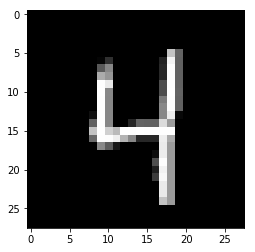

In [34]:
plt.figure(0)
plt.imshow(X_train[91].reshape((28, 28)), cmap='gray', interpolation='none')
print (y_train[91])
plt.show()

**Implementation.** Now code another ```get_acc()``` and try different values of K on our dataset.

In [35]:
def get_acc(kx):
    #TODO
    pass

#print (get_acc(kx=))